Trigger time = 0.5021329999999999s


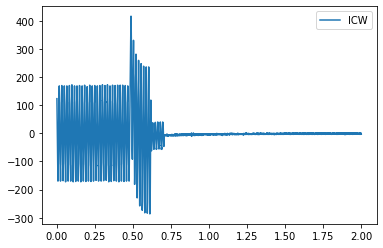

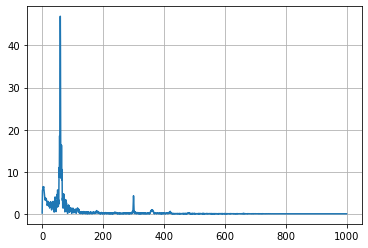

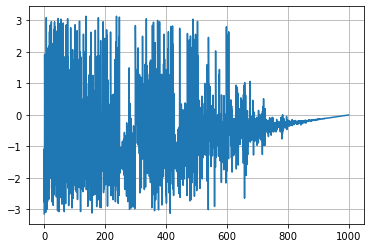

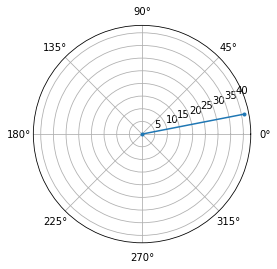

In [6]:
import matplotlib.pyplot as plt
from comtrade import Comtrade
import plotly.graph_objects as go
from antialising import Filtro
from array import array
from transformada import *
import numpy as np

rec = Comtrade()
rec.load("sample_files/test1.cfg", "sample_files/test1.dat")
print("Trigger time = {}s".format(rec.trigger_time))

senal_num=2

plt.figure()
plt.plot(rec.time, rec.analog[senal_num])
plt.legend([rec.analog_channel_ids[senal_num]])
plt.show()

#Filtro pasa bajas
t=rec.time
data=rec.analog[senal_num]
T = rec.cfg.sample_rates[0][1]/rec.cfg.sample_rates[0][0]        # numMuestras/muestrasPorSegundo
fs = rec.cfg.sample_rates[0][0]       # sample rate, Hz 
cutoff = (fs-60)/3      # desired cutoff frequency of the filter, Hz
order = 2

y=Filtro(fs,order,cutoff,data)

fig = go.Figure()
fig.add_trace(go.Scatter(y=data.tolist(),x=t.tolist(),line =  dict(shape =  'spline' ),name = 'signal with noise'))
fig.add_trace(go.Scatter(y = y.tolist(),x=t.tolist(),line =  dict(shape =  'spline' ),name = 'filtered signal'))
fig.show()

#ventaneo


#Filtro pasa banda


#Transformada
N=rec.cfg.sample_rates[0][1]
Tf=1/rec.cfg.sample_rates[0][0]
SOL=FFT(y)
SOL_f=FFT_f(N,Tf)

SOL_abs=2.0/N * np.abs(SOL[0:N//2])
SOL_angle=np.angle(SOL)[0:N//2]

plt.plot(SOL_f, SOL_abs)
plt.grid()
plt.show()
plt.plot(SOL_f, SOL_angle)
plt.grid()
plt.show()

try:
    i=np.where(SOL_f==60)
    j=i[0][0]#fasor de 60Hz
    plt.polar([0,SOL_angle[j]],[0,SOL_abs[j]],marker='.')
except:
    print("No hay valor de 60Hz exacto")


